# Detecting COVID-19 in X-Ray Images

This notebook is a re-implemenation of the Python code found in "Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning" (https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/). 

For the most part this Notebook takes the same algorithmic steps as the original article where (if) I make changes I note this.

I have split the code in various 'blocks' so that I can combine the comments fromt the original post with some of the embedded comments in the code itself. I did this becasue this gave me more clarity on what Adrian's code is doing.  Also in many cases, I have separated Adrian's original code (as shown in his blog) post into seprate blocks, again accompanied by his comments or some personal minor observations.

## References

* PyImageSearch. https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

* Visualize Class Activation Maps. https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

* Dataset used to get the COVID-19 images. Some useful comments in the Background and Motivation sectoin. https://github.com/ieee8023/covid-chestxray-dataset

## Notes
 * My virtual environment is `conda` based. There is an `environment.yml` file in the repo for his project that should help reproduce my work.

## Setup the Environment

Import the necessary packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

## Arguments

The original Python code form Adrian gets commands from the command line. Here in this notebook I set the variables directly in the code that follows. The variable names reflect the options in the `argparse` calls in the original code

In [2]:
dataset = "dataset/"
plot = "plot.png"
model_name = "covid19.model"

## Initialize Training Parametes

Initialize the initial learning rate, number of epochs to train for, and batch size

In [3]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

## Load and Pre-Process the X-Ray data

The code has been slightly changed to account for the fact that in this notebook we don't get the parameters fromt the command line, but are directly assigned to variables as seen in the "Arguments" section above.

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

imagePaths = list(paths.list_images(dataset))

data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [5]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

Next we will one-hot encode our labels and create the training/testing splits. 

In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); print(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.20, 
                                                  stratify=labels, 
                                                  random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, 
                              fill_mode="nearest")

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## Data Augmentation

Since we have so few images, we want to 'increase' the number of samples available to the model via data augmentation. This will help the model generalize.  The code here uses the original data augmentation that was in the original post.  We could investigate other techniques but not sure if this would be worth it here, sine this work is only foe eductaional persons. (**NB** Some people in the comments in the original post appear strongly object to Adrian's work, but for the record Adrain has been very clear about the purpose of his post. It is in that origianl spirit (so I can learn and it is a good exercise for me to get familar with TF 2.0) that I created this Jupyter notebook

The model used as the basis (for transfer learning) is **VGG16**

The following block of code sets up the *fine tunning* of the `VGG16` model

* Instantiates the VGG16 network with weights pre-trained on ImageNet, leaving off the fully connected (FC) layer head.

* Constructs a new fully-connected layer head consisting of POOL => FC = SOFTMAX layers and appends it on top of VGG16.

* Freezes the CONV weights of VGG16 such that only the FC layer head will be trained.

If you want to see what lines do what, refer to the original post.

In [7]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", 
                  include_top=False, 
                  input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
#headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

## Compile and train the model

The following block ompiles the network with learning rate decay and the Adam optimizer. Given that this is a 2-class problem, we use "binary_crossentropy" loss rather than categorical crossentropy.

In [8]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 2s 413ms/step - loss: 0.7769 - accuracy: 0.4750 - val_loss: 0.5161 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 0s 73ms/step - loss: 0.6695 - accuracy: 0.5750 - val_loss: 0.5060 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 0s 71ms/step - loss: 0.6695 - accuracy: 0.5750 - val_loss: 0.4970 - val_accuracy: 0.7500
Epoch 4/25
5/5 [==============================] - 0s 70ms/step - loss: 0.6700 - accuracy: 0.6000 - val_loss: 0.4865 - val_accuracy: 0.8750
Epoch 5/25
5/5 [==============================] - 0s 68ms/step - loss: 0.6329 - accuracy: 0.6000 - val_loss: 0.4731 - val_accuracy: 0.8750
Epoch 6/25
5/5 [==============================] - 0s 78ms/step - loss: 0.6899 - accuracy: 0.5250 - val_loss: 0.

## Evaluate the Model

For evaluation, we first make predictions on the testing set and grab the prediction indices. We then generate and print out a classification report using scikit-learn’s helper utility. Next we’ll compute a confusion matrix for further statistical evaluation:

In [9]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [10]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


## Plot Training Accuracy

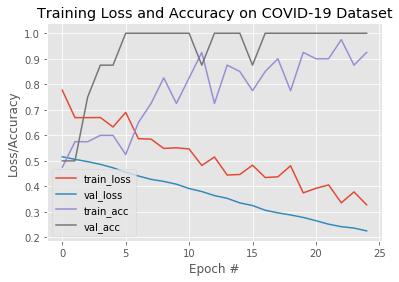

In [11]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot)

## Save the Model to Disk

In [12]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save(model_name, save_format="h5")

[INFO] saving COVID-19 detector model...
